MAE: 0.20
R² Score: 0.99


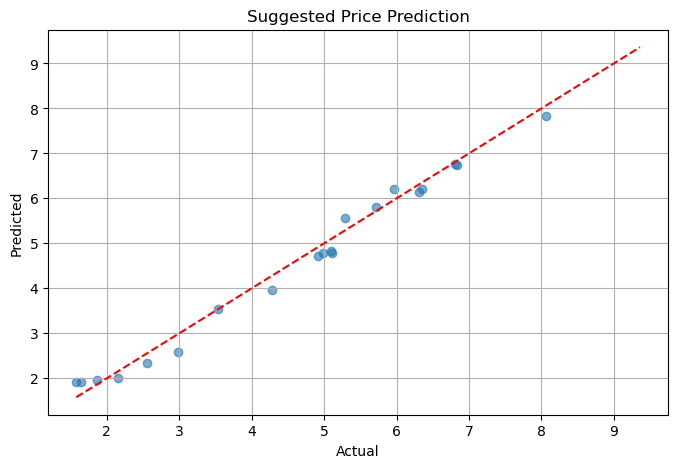

['suggested_price_model.pkl']

In [5]:
# Suggested filename: predict_suggested_price.ipynb

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv('enriched_products.csv')

# Convert dates if needed
df['expirationDate'] = pd.to_datetime(df['expirationDate'], errors='coerce')
df['lastUpdated'] = pd.to_datetime(df['lastUpdated'], errors='coerce')
df['updatedAt'] = pd.to_datetime(df['updatedAt'], errors='coerce')

# Handle missing target
df = df[df['suggestedPrice'].notnull()]

# Feature selection
features = [
    'currentPrice', 'originalPrice', 'cost', 'stock', 'maxStock',
    'minStockLevel', 'isPerishable', 'daysUntilExpiry', 'margin',
    'demand', 'clearanceRate', 'wasteReduction', 'mlScore',
    'priceFactors.expirationUrgency', 'priceFactors.stockLevel',
    'priceFactors.timeOfDay', 'priceFactors.demandForecast',
    'priceFactors.competitorPrice', 'priceFactors.seasonality',
    'priceFactors.marketTrend'
]

X = df[features]
y = df['suggestedPrice']

# Fill missing values
X = X.fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot predictions
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Suggested Price Prediction')
plt.grid(True)
plt.show()

# Save model
joblib.dump(model, 'suggested_price_model.pkl')


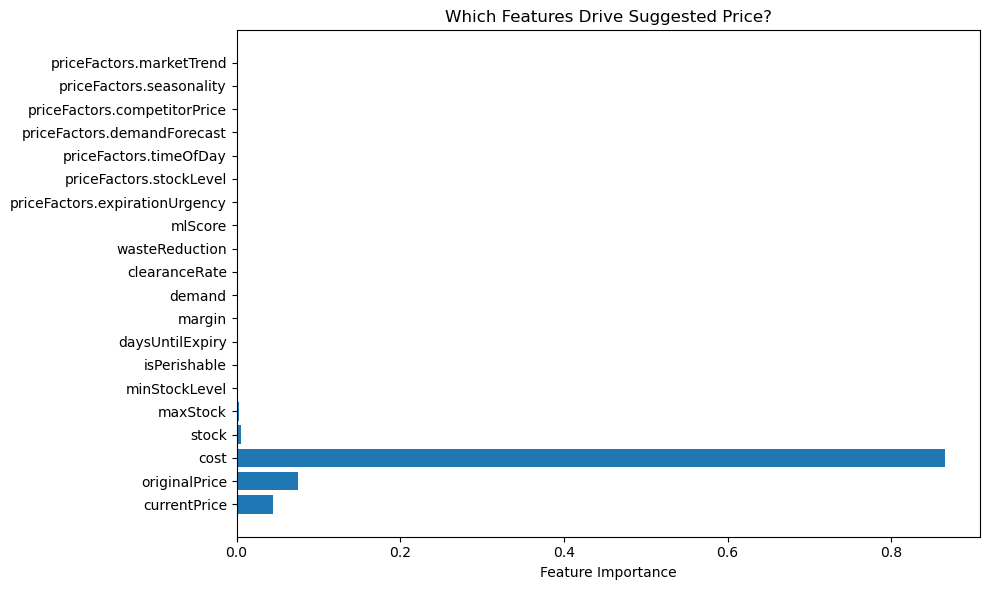

In [7]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Which Features Drive Suggested Price?")
plt.tight_layout()
plt.show()


MAE: 0.18
R² Score: 0.99


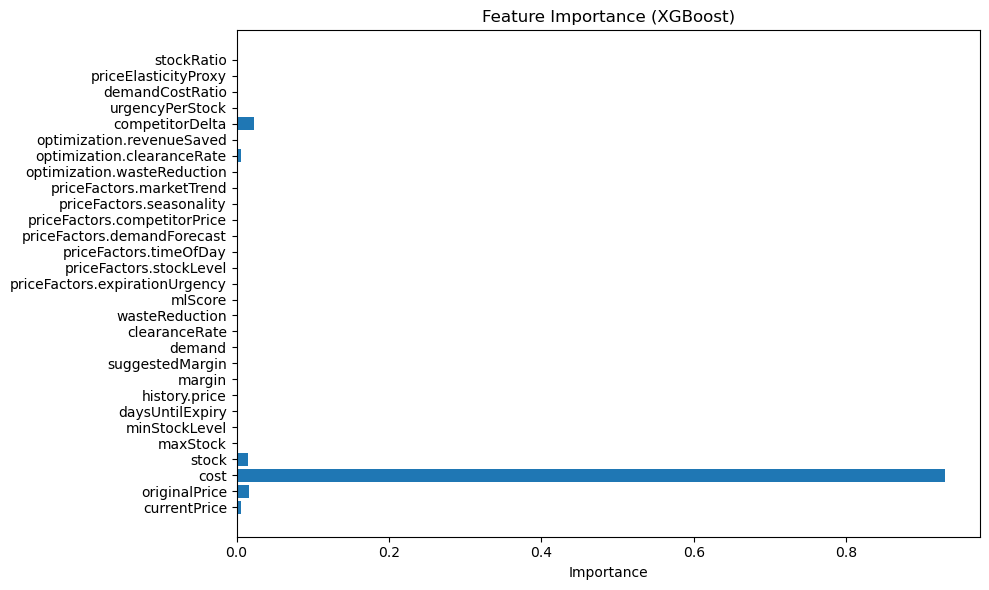

In [15]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import joblib

# Load CSV
df = pd.read_csv("enriched_pricing_data.csv")

# Drop non-numeric/object columns we don't need
df = df.drop(columns=['productId', 'supplierId', 'supplierName', 'name', 'sku', 'category', 'expirationDate', 'lastUpdated', 'updatedAt', 'optimization.lastOptimization'])

# --- Feature Engineering ---
df['competitorDelta'] = df['currentPrice'] - df['priceFactors.competitorPrice']
df['urgencyPerStock'] = df['priceFactors.expirationUrgency'] / (df['stock'] + 1)
df['demandCostRatio'] = df['demand'] / (df['cost'] + 1)
df['priceElasticityProxy'] = (df['originalPrice'] - df['currentPrice']) / (df['demand'] + 1)
df['stockRatio'] = df['stock'] / (df['maxStock'] + 1)

# Drop any rows where target is missing
df = df[df['suggestedPrice'].notnull()]

# Define target and features
target = 'suggestedPrice'
X = df.drop(columns=[target])
y = df[target]

# Drop columns that are string or not usable
X = X.select_dtypes(include=['number'])

# Preprocessing
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train XGBoost Regressor
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

# Save model
joblib.dump(model, "suggested_price_xgb_model.pkl")

# Feature importance
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


MAE: 0.17
R² Score: 0.99


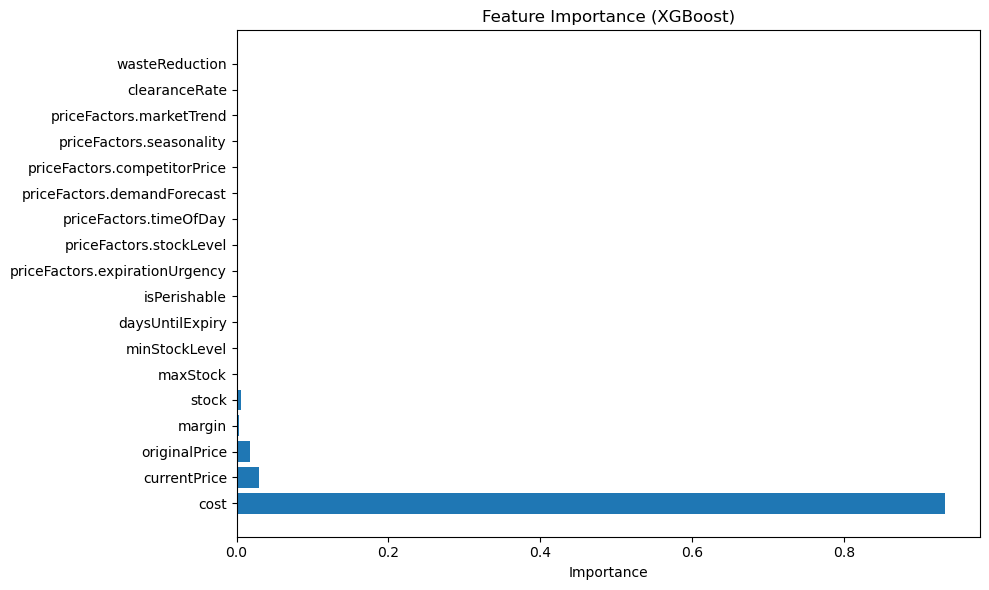

In [27]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import joblib

# Load CSV
df = pd.read_csv("enriched_pricing_data.csv")

# Drop rows with missing target
df = df[df['suggestedPrice'].notnull()]

# Select only the features you want
selected_features = [
    'cost', 'currentPrice', 'originalPrice', 'margin',
    'stock', 'maxStock', 'minStockLevel',
    'daysUntilExpiry', 'isPerishable',
    'priceFactors.expirationUrgency', 'priceFactors.stockLevel', 'priceFactors.timeOfDay',
    'priceFactors.demandForecast', 'priceFactors.competitorPrice', 
    'priceFactors.seasonality', 'priceFactors.marketTrend',
    'clearanceRate', 'wasteReduction'
]

# Optional: remove expirationDate if you're using daysUntilExpiry already
# If 'expirationDate' is needed (e.g. for other modeling), include its parsing

# Define features and target
X = df[selected_features]
y = df['suggestedPrice']

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

# Save model
joblib.dump(model, "suggested_price_xgb_model.pkl")

# Plot feature importances
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(selected_features, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


priceFactors.seasonality           0.266482
priceFactors.marketTrend           0.274080
priceFactors.expirationUrgency     0.278806
priceFactors.demandForecast        0.280575
wasteReduction                     0.287380
priceFactors.timeOfDay             0.295932
priceFactors.stockLevel            0.296552
priceFactors.competitorPrice       0.300838
clearanceRate                      0.302913
isPerishable                       0.451261
cost                               1.824645
currentPrice                       2.237555
originalPrice                      2.351602
daysUntilExpiry                    8.010447
margin                             8.678256
minStockLevel                     12.194265
stock                             84.459792
maxStock                          89.532272
dtype: float64
✅ Descriptive stats of selected features:
                                    mean        std    min     max
cost                              4.2792   1.824645   1.40    8.27
currentPrice     

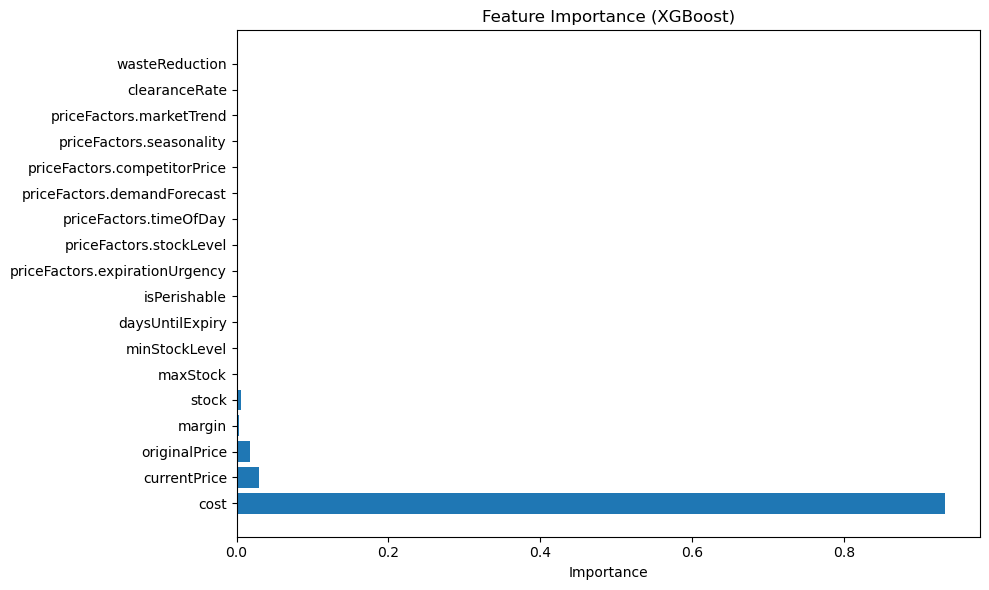

In [33]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import joblib

# Load CSV
df = pd.read_csv("enriched_products.csv")

# Drop rows where target is missing
df = df[df['suggestedPrice'].notnull()]

# Define the features to use
selected_features = [
    'cost', 'currentPrice', 'originalPrice', 'margin',
    'stock', 'maxStock', 'minStockLevel',
    'daysUntilExpiry', 'isPerishable',
    'priceFactors.expirationUrgency', 'priceFactors.stockLevel', 'priceFactors.timeOfDay',
    'priceFactors.demandForecast', 'priceFactors.competitorPrice', 
    'priceFactors.seasonality', 'priceFactors.marketTrend',
    'clearanceRate', 'wasteReduction'
]

print(df[selected_features].std().sort_values())


# --- Convert all selected columns to numeric ---
for col in selected_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print summary statistics to inspect values
print("✅ Descriptive stats of selected features:")
print(df[selected_features].describe().transpose()[['mean', 'std', 'min', 'max']])

# Define X and y
X = df[selected_features]
y = df['suggestedPrice']

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train the model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"\n✅ MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"✅ R² Score: {r2_score(y_test, y_pred):.2f}")

# Save model
joblib.dump(model, "suggested_price_xgb_model.pkl")

# Feature importances
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(selected_features, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


isPerishable                          0.423485
wasteReduction                        3.157923
priceFactors.marketTrend              5.255689
priceFactors.demandForecast           5.684206
priceFactors.seasonality              7.115343
clearanceRate                         8.285727
margin                                8.471815
priceFactors.timeOfDay                8.588870
minStockLevel                         9.708166
priceFactors.stockLevel               9.738737
priceFactors.expirationUrgency       29.377876
stock                                46.269644
maxStock                             67.845067
daysUntilExpiry                      80.219039
cost                              20635.746724
currentPrice                      29861.668763
priceFactors.competitorPrice      30035.920638
originalPrice                     33315.887268
dtype: float64
✅ Descriptive stats of selected features:
                                        mean           std    min       max
cost                 

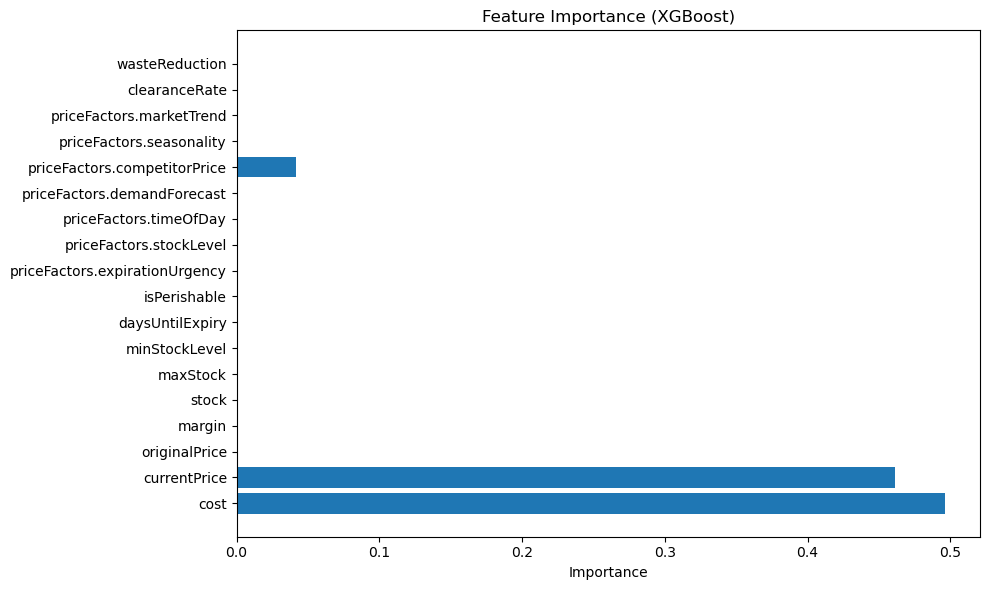


✅ Predictions and mlScores saved to predicted_prices_with_score.json


['imputer.pkl']

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load CSV
df = pd.read_csv("product_cleaned.csv")

# Drop rows where target is missing
df = df[df['suggestedPrice'].notnull()]

# Define the features to use
selected_features = [
    'cost', 'currentPrice', 'originalPrice', 'margin',
    'stock', 'maxStock', 'minStockLevel',
    'daysUntilExpiry', 'isPerishable',
    'priceFactors.expirationUrgency', 'priceFactors.stockLevel', 'priceFactors.timeOfDay',
    'priceFactors.demandForecast', 'priceFactors.competitorPrice', 
    'priceFactors.seasonality', 'priceFactors.marketTrend',
    'clearanceRate', 'wasteReduction'
]

print(df[selected_features].std().sort_values())

# Convert all selected columns to numeric
for col in selected_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print descriptive statistics
print("✅ Descriptive stats of selected features:")
print(df[selected_features].describe().transpose()[['mean', 'std', 'min', 'max']])

# Define X and y
X = df[selected_features]
y = df['suggestedPrice']

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
print(f"\n✅ MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"✅ R² Score: {r2_score(y_test, y_pred):.2f}")

# Save model
joblib.dump(model, "suggested_price_xgb_model.pkl")

# Plot feature importances
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(selected_features, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# === Predict on full data for suggestedPrice + mlScore ===
suggested_price_all = model.predict(X_imputed)

# mlScore calculation using variance of leaf indices
# leaf_indices = model.apply(X_imputed)  # shape: (n_samples, n_trees)
# leaf_variance = np.var(leaf_indices, axis=1)
# max_var = np.max(leaf_variance)
# ml_score_all = 1 - (leaf_variance / (max_var + 1e-8))  # Normalize to 0–1

# # Add to DataFrame
# df['suggestedPrice_predicted'] = np.round(suggested_price_all, 2)
# df['mlScore'] = np.round(ml_score_all, 3)


from sklearn.preprocessing import MinMaxScaler

# --- STEP 1: Tree-level prediction disagreement ---
booster = model.get_booster()
n_trees = booster.num_boosted_rounds()

tree_preds = []
for i in range(n_trees):
    pred = booster.predict(xgb.DMatrix(X_imputed), iteration_range=(i, i + 1), output_margin=True)
    tree_preds.append(pred)

tree_preds = np.array(tree_preds).T  # shape: (n_samples, n_trees)

# --- STEP 2: Standard deviation across trees ---
std_dev = np.std(tree_preds, axis=1)

# --- STEP 3: Confidence = lower std → higher confidence ---
inv_std = 1 / (std_dev + 1e-6)

# Optional: Apply log transform to spread values more
log_inv_std = np.log1p(inv_std)

# Normalize
scaler = MinMaxScaler()
normalized_confidence = scaler.fit_transform(log_inv_std.reshape(-1, 1))

# # Rescale to desired range
# ml_score_all = 0.70 + normalized_confidence.flatten() * (0.99 - 0.70)
# Use previous normalized_confidence
# Stretch top scores
ml_score_all = 0.70 + (normalized_confidence.flatten() ** 0.3) * (0.99 - 0.70)


# Assign back to dataframe
df['suggestedPrice_predicted'] = np.round(suggested_price_all, 2)
df['mlScore'] = np.round(ml_score_all, 3)




# Export for Mongo or review
df[['productId', 'suggestedPrice_predicted', 'mlScore']].to_json("predicted_prices_with_score.json", orient="records")

print("\n✅ Predictions and mlScores saved to predicted_prices_with_score.json")
# ✅ Save model and imputer for reuse in backend API
joblib.dump(model, "suggested_price_xgb_model.pkl")
joblib.dump(imputer, "imputer.pkl")  # Saves the imputer used during training



✅ MAE: 450.89
✅ R² Score: 0.9957
✅ 3-Fold CV R² Mean: 0.9212


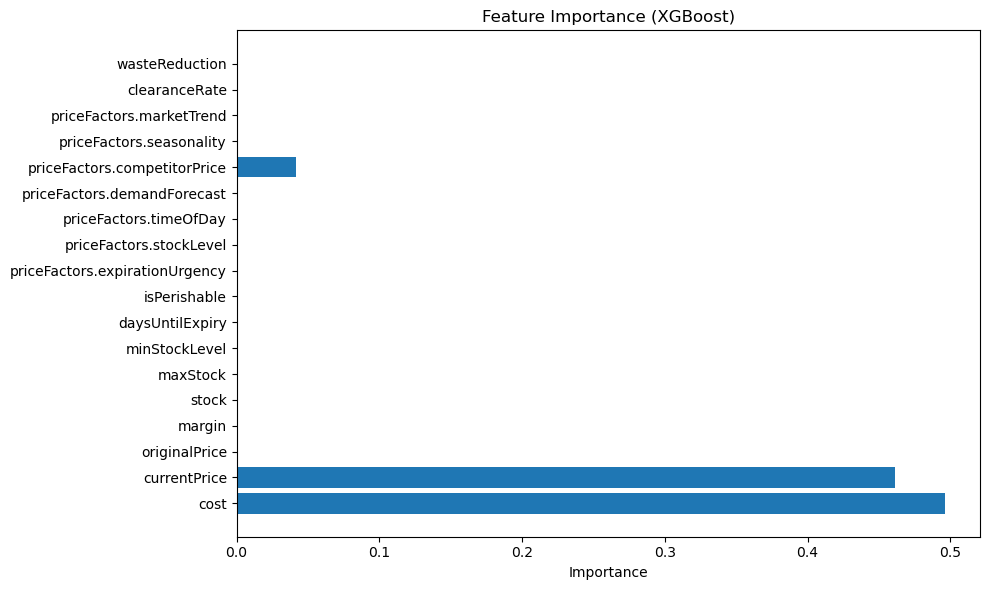

In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import numpy as np

# === Load CSV ===
df = pd.read_csv("product_cleaned.csv")
df = df[df['suggestedPrice'].notnull()]

# === Selected features ===
selected_features = [
    'cost', 'currentPrice', 'originalPrice', 'margin',
    'stock', 'maxStock', 'minStockLevel', 'daysUntilExpiry', 'isPerishable',
    'priceFactors.expirationUrgency', 'priceFactors.stockLevel', 'priceFactors.timeOfDay',
    'priceFactors.demandForecast', 'priceFactors.competitorPrice', 
    'priceFactors.seasonality', 'priceFactors.marketTrend',
    'clearanceRate', 'wasteReduction'
]

# Ensure numeric types
for col in selected_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# === Prepare X and y ===
X = df[selected_features]
y = df['suggestedPrice']

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# === Train model ===
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# === Evaluation ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"✅ MAE: {mae:.2f}")
print(f"✅ R² Score: {r2:.4f}")

# === Cross-validation (faster) ===
cv_scores = cross_val_score(model, X_imputed, y, cv=3, scoring='r2')
print(f"✅ 3-Fold CV R² Mean: {cv_scores.mean():.4f}")

# === Predict full dataset ===
suggested_price_all = model.predict(X_imputed)

# === Confidence Score (mlScore) ===
booster = model.get_booster()
n_trees = booster.num_boosted_rounds()

# Tree-level predictions
tree_preds = []
for i in range(n_trees):
    pred = booster.predict(xgb.DMatrix(X_imputed), iteration_range=(i, i+1), output_margin=True)
    tree_preds.append(pred)
tree_preds = np.array(tree_preds).T

# Standard deviation across trees
std_dev = np.std(tree_preds, axis=1)
inv_std = 1 / (std_dev + 1e-6)
log_inv_std = np.log1p(inv_std)

# Normalize
scaler = MinMaxScaler()
normalized_confidence = scaler.fit_transform(log_inv_std.reshape(-1, 1))

# Stretch top scores
ml_score_all = 0.70 + (normalized_confidence.flatten() ** 0.3) * (0.99 - 0.70)

# Add predictions to DataFrame
df['suggestedPrice_predicted'] = np.round(suggested_price_all, 2)
df['mlScore'] = np.round(ml_score_all, 3)

# === Save Output ===
df[['productId', 'suggestedPrice_predicted', 'mlScore']].to_json("predicted_prices_with_score_cleaned.json", orient="records")
joblib.dump(model, "suggested_price_xgb_model_cleaned.pkl")
joblib.dump(imputer, "imputer_cleaned.pkl")

# === Feature Importance Plot (optional) ===
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(selected_features, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

# === Load CSV ===
df = pd.read_csv("product_cleaned.csv")
df = df[df['suggestedPrice'].notnull()]

# === Define features ===
selected_features = [
    'cost', 'currentPrice', 'originalPrice', 'margin',
    'stock', 'maxStock', 'minStockLevel', 'daysUntilExpiry', 'isPerishable',
    'priceFactors.expirationUrgency', 'priceFactors.stockLevel', 'priceFactors.timeOfDay',
    'priceFactors.demandForecast', 'priceFactors.competitorPrice',
    'priceFactors.seasonality', 'priceFactors.marketTrend',
    'clearanceRate', 'wasteReduction'
]

# === Convert to numeric ===
for col in selected_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

X = df[selected_features]
y = df['suggestedPrice']

# === Impute ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# === Train Model ===
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# === Evaluation ===
y_pred = model.predict(X_test)
print("✅ MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("✅ R²:", round(r2_score(y_test, y_pred), 4))

# === mlScore Calculation ===
booster = model.get_booster()
n_trees = booster.num_boosted_rounds()

tree_preds = []
for i in range(n_trees):
    pred = booster.predict(xgb.DMatrix(X_imputed), iteration_range=(i, i+1), output_margin=True)
    tree_preds.append(pred)
tree_preds = np.array(tree_preds).T
std_dev = np.std(tree_preds, axis=1)
inv_std = 1 / (std_dev + 1e-6)
log_inv_std = np.log1p(inv_std)

scaler = MinMaxScaler()
confidence_scaled = scaler.fit_transform(log_inv_std.reshape(-1, 1))
ml_score_all = 0.70 + (confidence_scaled.flatten() ** 0.3) * (0.99 - 0.70)

# === Save predicted values ===
df['suggestedPrice_predicted'] = np.round(model.predict(X_imputed), 2)
df['mlScore'] = np.round(ml_score_all, 3)

df[['productId', 'suggestedPrice_predicted', 'mlScore']].to_json("predicted_prices_with_score_cleaned.json", orient="records")
print("✅ JSON saved")

# === Save pkl files ===
joblib.dump(model, "suggested_price_xgb_model_cleaned.pkl")
joblib.dump(imputer, "imputer_cleaned.pkl")
joblib.dump(scaler, "confidence_scaler.pkl")
print("✅ PKL files saved: model, imputer, scaler")


✅ MAE: 450.89
✅ R²: 0.9957
✅ JSON saved
✅ PKL files saved: model, imputer, scaler
